# Anonimización Pulpocon 2023

## Datos y privacidad

En la era del Big Data, la información es uno de los bienes más preciados, y esto es así porque podemos sacar valor de ella gracias a la gran cantidad de información disponible y a las técnicas de análisis de datos y machine learning que se han desarrollado.

Este valor pasa por ofrecer más y mejores productos y servicios o por mejorar la eficiencia y eficacia de la organización, pero también por garantizar su seguridad y la de sus clientes.

La seguridad no solo hace ahorrar tiempo y dinero en solventar los incidentes que se puedan producir, sino que también aumentará la confianza y satisfacción con nuestra organización.

En este contexto, la privacidad de los dueños de la información disponible está en peligro. Se hace necesario controlar y proteger la información personal, todos aquellos datos que sobre una persona identificable por un atributo o la combinación de varios.

La UE estableció el GDPR para brindar protección sobre nuestros datos personales. Exige un consentimiento claro y específico para tratar datos personales, da más control a los ciudadanos sobre sus datos y obliga a las empresas a proteger esa información. Además, tiene carácter retroactivo, los que prácticamente imposibilita el procesamiento de datos históricos.

Por suerte, tenemos herramientas para proteger datos personales, tratando de mantener su valor, hasta el punto en el que es imposible, o casi, identificar los dueños originales de los datos, haciendo que no sean datos personales y, por tanto, ya no es necesario acogerse a la medidas específicas de la GDPR: **la anonimización**.

### Dataset de detección de fraude bancario

Para esta parte de anonimización vamos a utilizar un dataset bancario sobre los préstamos a sus clientes.

Dataset: https://www.kaggle.com/datasets/mishra5001/credit-card

De momento, no nos vamos a centrar demasiado en el significado real de estos datos, ya que la anonimización sería un paso previo a su procesamiento.

In [106]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans

from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [107]:
df = pd.read_csv('data/application_data_selected.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   SK_ID_CURR        307511 non-null  int64  
 1   AMT_INCOME_TOTAL  307511 non-null  float64
 2   AMT_CREDIT        307511 non-null  float64
 3   DAYS_BIRTH        307511 non-null  int64  
 4   DAYS_EMPLOYED     307511 non-null  int64  
 5   TARGET            307511 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 14.1 MB


El dataset original tiene muchísimas columnas, así que he seleccionado unas pocas que se entienden bien para que el taller sea más ágil.

In [108]:
selected_cols = [
    'SK_ID_CURR',
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'TARGET',
 ]

data = df[selected_cols].copy()

data.head()

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,TARGET
0,100002,202500.0,406597.5,-9461,-637,1
1,100003,270000.0,1293502.5,-16765,-1188,0
2,100004,67500.0,135000.0,-19046,-225,0
3,100006,135000.0,312682.5,-19005,-3039,0
4,100007,121500.0,513000.0,-19932,-3038,0


Descripción de la columnas:

- SK_ID_CURR: id del préstamo.

- AMT_INCOME_TOTAL: ingresos del cliente.

- AMT_CREDIT: importe del préstamo.

- DAYS_BIRTH: edad del cliente en días en el momento de la solicitud.

- DAYS_EMPLOYED: cuántos días antes de la solicitud la persona empezó a trabajar.

- TARGET: cliente con dificultades de pago (1 - tuvo retrasos en el pago de más de X días en al menos una de las primeras Y cuotas del préstamo, 0 - todos los demás casos

Como vemos, contiene información que pueden ayudar a identificar a los clientes, además de información sensible como es la financiera.

Con un profiler, u otras herramientas de visualización, podemos tener una mejor idea de como son nuestros datos

In [109]:
prof = ProfileReport(data)
prof.to_file(output_file='reports/application_data_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/iabad/anaconda3/envs/ml-py39/lib/python3.9/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  discretized_df.loc[:, column] = self._discretize_column(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

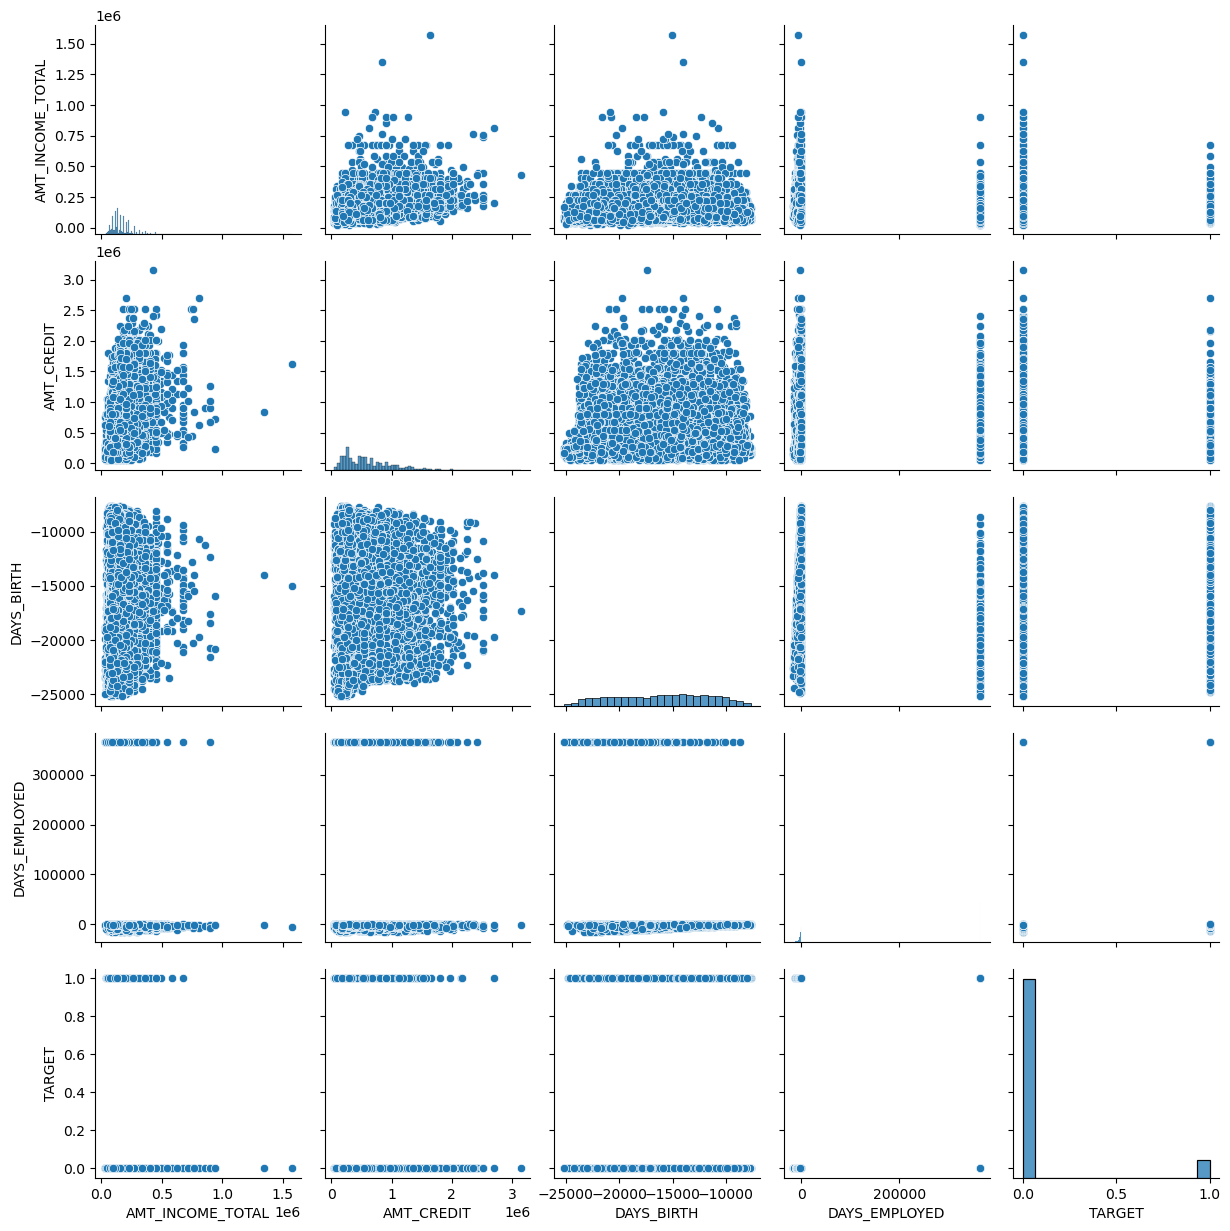

In [110]:
sns.pairplot(data.drop('SK_ID_CURR', axis=1).sample(10000, axis=0))

In [111]:
data['DAYS_EMPLOYED'].value_counts()

 365243    55374
-200         156
-224         152
-230         151
-199         151
           ...  
-13961         1
-11827         1
-10176         1
-9459          1
-8694          1
Name: DAYS_EMPLOYED, Length: 12574, dtype: int64

Tenemos que decidir qué columnas anonimizamos y, realmente, todas serían susceptibles, puesto que son datos personales. Sin embargo:

- Los identificadores solo sirven para identificar préstamos, no van a aportar información si los anonimizamos. Ya nos encargaremos más tarde de ellos.

- TARGET es una variable binaria, dificil de anonimizar sin romper su significado, ya que tiene dos posibles valores. Además, parece ser la variable a predecir en el futuro porcesamiento de los datos, así que trataremos de no tocarla si no es necesario.

In [112]:
sensitive_cols = [
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED'
 ]

Como podemos comprobar, este dataset tiene identificadores, pero en principio podríamos pensar que son privados y solo la entidad propietaria sabe a qué usuario se corresponden.

Sin embargo, esta técnica por si sola no basta para anonimizar cualquier información, solamente sirve para dificultar la identificación de las personas que se encuentran en esos datos.

Ejemplos de estos tipos de técnicas son:

- Seudonimización (pseudonymization): sustituir identificadores personales por identificadores sintéticos privados.

- Enmascarado (masking): ocultar, total o parcialmente, la información personal, sustituyéndola por otros caracteres.

- Intercambio (swapping): intercambiar información sensible en un conjunto ordenado, bien entre diferentes datos de la misma persona o entre datos de distintas personas.

- Reducción de dimensionalidad (PCA): reducen el número de columnas tratando de conservar las propiedades de los datos originales, agregando columnas relacionadas para dar lugar al mínimo numero de columnas independientes.

## Anonimización

Eliminar o reducir al mínimo el riesgo de identificación de las personas a partir de un conjunto de datos.

Se debe asumir que el adversario tiene la mayor cantidad posible de información externa sobre los usuarios, y evaluar así el riesgo de re-identificación.

Los dos principales mecanismos para anonimizar un dataset son:

- **Generalización**: se busca agregar los datos de distintos usuarios para evitar su re-identificación.

- **Randomización**: se busca añadir una distorsión a los datos, de modo que no se puedan relacionar con su valor original.

Es necesario tener en cuenta que estas transformaciones de los datos hacen que pierdan parte de su significado original, pero suelen ser necesarias para garantizar una cierta privacidad. Típicamente, cuánto más agresiva la anonimización, más información se perderá, haciendo que los datos pierdan utilidad para futuros usos, como sacar modelos estadísticos de ellos.

En estos contextos, es necesario jugar con la privacidad y la utilidad para alcanzar el equilibrio deseado entre ambas, por lo que precisamos de formas de medir ambas variables.

### MSE (Error cuadrático medio)

El MSE es una de las métricas más utilizada para medir pérdida de utilidad. Cuanto mayor sea el error, más información perdemos.

Es importante notar que este error saldrá elevado al cuadrado, para saber el error medio en la escala de nuestros datos será necesario hacer la raíz cuadrada.

In [113]:
def mse_by_col(df1, df2, squared=True):
    if df1.columns.difference(df2.columns).size > 0 or df1.shape != df2.shape:
        raise ValueError('Dataframes must have same shape and columns')
    
    result = []
    cols = df1.columns
    
    for col in cols:
        result.append(mean_squared_error(df1[col], df2[col], squared=squared))
        
    return pd.Series(result, index=cols)

### K-anonymity

Implica ocultar la identidad de los individuos en un conjunto de datos al asegurarse de que cada fila sea indistinguible entre al menos "k" otros registros en términos de atributos compartidos, protegiendo así la privacidad mientras se mantiene la utilidad de los datos. Está muy orientada a la privacidad por generalización.

"K", por tanto, funciona como una métrica de privacidad: cuanto mayor sea "k" en nuestro dataset, mayor privacidad tendremos.

En la práctica, "k" se calcula como el número de veces que se repite en nuestro dataset la combinación de valores de una fila que menos se repite. Sería como hacer un group_by de todas las columnas y ver el grupo que menos registros contiene.

In [114]:
def k_anonymity(df, sizes=False):
    val_groups = df.groupby(list(df.columns))
    groups_count = list(map(int, val_groups.size()))
    if sizes:
        return groups_count
    return min(groups_count)

In [115]:
k_anonymity(data)

1

El "k" de nuestro dataset inicial es 1, lo que quiere decir que hay filas cuya combinación de valores es única. Pero era esperable, ya que sabíamos que hay identificadores únicos en la primera columna.

**Primer paso de toda anonimización**: eliminar identificadores únicos

In [116]:
data.drop('SK_ID_CURR', axis='columns', inplace=True)
k_anonymity(data)

1

Vemos que sigue sin cumplir k-anonimity, así que será necesario transformar estos datos para garantizar su privacidad.

### Mecanismos de generalización

La operaciones de generalización más comunes sobre las columnas de un dataset son K-means, redondeo y categorización.

#### K-means

K-Means es un algoritmo de aprendizaje no supervisado que agrupa un conjunto de datos en "k" grupos basados en sus características similares.

Funciona asignando puntos de datos al grupo cuyo centroide (punto medio) esté más cercano, y luego actualiza los centroides al calcular el promedio de los puntos asignados. Este proceso se repite iterativamente hasta que los centroides convergen y los grupos se vuelven estables.

In [117]:
def k_means(df, n_clusters=8):
    kmeans = KMeans(n_clusters=n_clusters, random_state=40)
    kmeans.fit(df)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    return pd.DataFrame(centroids[labels], columns=df.columns)

def k_means_by_col(df, n_clusters=8):
    new_df = df.copy()
    for col in df.columns:
        new_df[[col]] = k_means(df[[col]], n_clusters)
        
    return new_df

##### Primera forma de generalizar: Kmeans de todo el dataset

In [118]:
data_k4 = data.copy()
data_k4[sensitive_cols] = k_means(data[sensitive_cols], n_clusters=4)
data_k4


/home/iabad/anaconda3/envs/ml-py39/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,TARGET
0,137402.828414,2.781133e+05,-15790.609319,72470.770581,1
1,234557.986317,1.327302e+06,-16427.058817,45978.768906,0
2,137402.828414,2.781133e+05,-15790.609319,72470.770581,0
3,137402.828414,2.781133e+05,-15790.609319,72470.770581,0
4,179848.917108,6.991950e+05,-16183.624697,60369.034433,0
...,...,...,...,...,...
307506,137402.828414,2.781133e+05,-15790.609319,72470.770581,0
307507,137402.828414,2.781133e+05,-15790.609319,72470.770581,0
307508,179848.917108,6.991950e+05,-16183.624697,60369.034433,0
307509,137402.828414,2.781133e+05,-15790.609319,72470.770581,1


In [119]:
k_anonymity(data_k4)

1

In [120]:
k_anonymity(data_k4, sizes=True)

[132236, 12174, 105670, 9858, 44780, 2792, 1]

Vaya... esto no era lo que esperaba. Hemos encontrado un registro que no conseguimos agrupar con ningún otro de los 307510, ni usando tan solo 4 grupos.

In [121]:
data_k4['AMT_INCOME_TOTAL'].value_counts()

1.374028e+05    144410
1.798489e+05    115528
2.345580e+05     47572
1.170000e+08         1
Name: AMT_INCOME_TOTAL, dtype: int64

In [122]:
data_k4[data_k4['AMT_INCOME_TOTAL'] == 1.170000e+08]

,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,TARGET
12840,117000000.0,562491.0,-12615.0,-922.0,1


In [123]:
data.loc[12840]

AMT_INCOME_TOTAL    117000000.0
AMT_CREDIT             562491.0
DAYS_BIRTH             -12615.0
DAYS_EMPLOYED            -922.0
TARGET                      1.0
Name: 12840, dtype: float64

Hemos encontrado un outlier bastante notable en los ingresos totales, así que lo vamos a eliminar y volver a ejecutar K-means, a ver si así no tenemos grupos tan pequeños y mejoramos la privacidad

In [124]:
data.drop(12840, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

In [125]:
data_k4 = data.copy()
data_k4[sensitive_cols] = k_means(data[sensitive_cols], n_clusters=4)
k_anonymity(data_k4)

/home/iabad/anaconda3/envs/ml-py39/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1603

In [126]:
print('MSE de Kmeans general:')
print(mse_by_col(data, data_k4, squared=False))
print('MSE medio:', mse_by_col(data, data_k4, squared=False).mean())

MSE de Kmeans general:
AMT_INCOME_TOTAL    102784.744595
AMT_CREDIT          170757.655389
DAYS_BIRTH            3607.119777
DAYS_EMPLOYED        76420.634885
TARGET                   0.000000
dtype: float64
MSE medio: 70714.0309294078


Podemos ver como tenemos un K de 1603, lo que implica un riesgo de re-identificación de 0.0624%, por lo que la privacidad es bastante alta. Sin embargo, al hacer tan solo 4 grupos de valores en todo el dataset, tenemos mucha pérdida de utilidad. Tal vez haciendo más grupos conseguiríamos mejorar la utilidad sin sacrificar demasiada privacidad.

##### Segunda forma de generalizar: Kmeans por columnas

Al generalizar por columnas perdemos menos utilidad, pero tenemos muchas posibles combinaciones de valores cuando el número de columnas es muy grande, por lo que es fácil que haya combinaciones únicas

In [127]:
data_k4_bycol = data.copy()
data_k4_bycol[sensitive_cols] = k_means_by_col(data[sensitive_cols], n_clusters=4)
data_k4_bycol

/home/iabad/anaconda3/envs/ml-py39/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/iabad/anaconda3/envs/ml-py39/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/iabad/anaconda3/envs/ml-py39/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/iabad/anaconda3/envs/ml-py39/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the w

,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,TARGET
0,224555.577197,5.519972e+05,-10599.803519,-1044.854115,1
1,224555.577197,1.500200e+06,-18385.297785,-1044.854115,0
2,114387.961704,2.379894e+05,-18385.297785,-1044.854115,0
3,114387.961704,2.379894e+05,-18385.297785,-3725.192413,0
4,114387.961704,5.519972e+05,-18385.297785,-3725.192413,0
...,...,...,...,...,...
307505,114387.961704,2.379894e+05,-10599.803519,-1044.854115,0
307506,114387.961704,2.379894e+05,-22226.916856,365243.000000,0
307507,114387.961704,5.519972e+05,-14492.892377,-8805.525156,0
307508,224555.577197,2.379894e+05,-10599.803519,-3725.192413,1


In [128]:
print('MSE de Kmeans por columnas:')
print(mse_by_col(data, data_k4_bycol, squared=False))
print('MSE medio', mse_by_col(data, data_k4_bycol, squared=False).mean())

MSE de Kmeans por columnas:
AMT_INCOME_TOTAL     57478.740463
AMT_CREDIT          127905.887362
DAYS_BIRTH            1166.545956
DAYS_EMPLOYED          851.200276
TARGET                   0.000000
dtype: float64
MSE medio 37480.47481136719


In [129]:
k_anonymity(data_k4_bycol)

1

In [130]:
k_anonymity(data_k4_bycol, sizes=True).count(1)

9

Parece que en este caso tenemos, más o menos, la mitad de pérdida de información que antes, pero no hemos conseguido cumplir k-anonimity. Hay 9 combinaciones de valores que son únicas. Tal vez haciendo menos grupos en alguna columna lo conseguiríamos.

#### Microagregaciones

Es una manera de garantizar k-anonymity que consiste en ir haciendo grupos de "k" registros similares de forma iterativa, hasta que todos los registros estén en un grupo de, al menos, ese tamaño.

In [131]:
def euclidean_distance(v1, v2):
    if type(v1) == pd.DataFrame or type(v2) == pd.DataFrame:
        return np.sqrt((v2 - v1).pow(2).sum(axis=1))
    else:
        return np.sqrt(np.sum((v2 - v1)**2))

def microaggregation(df, k):
    input_df = df.copy()
    output_df = df.copy()
    while len(input_df) >= 3*k:
        # (a) Compute the average record x˜ of all records in R. The average record is computed attribute-wise.
        # (b) Consider the most distant record xr to the average record x˜ using an appropriate distance.
        # (c) Find the most distant record xs from the record xr considered in the previous step.
        # (d) Form two clusters around xr and xs, respectively. One cluster contains xr and the k −1 records closest to xr. The other cluster contains xs and the k −1 records closest to xs.
        # (e) Take as a new dataset R the previous dataset R minus the clusters formed around xr and xs in the last instance of Step 1d
        
        mean_row = input_df.mean(axis=0)
        
        # r: Cluster más lejano a la media actual
        r_index = euclidean_distance(mean_row, input_df).idxmax()
        r_row = input_df.loc[r_index]
        r_distances = euclidean_distance(r_row, input_df)
        r_cluster_indexes = r_distances.nsmallest(k).index
        r_cluster = input_df.loc[r_cluster_indexes]
        r_cluster_mean = r_cluster.mean(axis=0)
        
        # s: Cluster más lejano a r
        s_index = r_distances.idxmax()
        s_row = input_df.loc[s_index]
        s_distances = euclidean_distance(s_row, input_df)
        s_cluster_indexes = s_distances.nsmallest(k).index
        s_cluster = input_df.loc[s_cluster_indexes]
        s_cluster_mean = s_cluster.mean(axis=0)
        
        # sustituimos en la salida los clusters por su media, y los eliminamos del conjunto de entrada
        output_df.loc[r_cluster.index] = r_cluster_mean.values
        output_df.loc[s_cluster.index] = s_cluster_mean.values
        
        input_df.drop(r_cluster.index, axis=0, inplace=True)
        input_df.drop(s_cluster.index, axis=0, inplace=True)
    
    if 3*k-1 > len(input_df) >= 2*k:
        # (a) compute the average record x˜ of the remaining records in R
        # (b) find the most distant record xr from x˜
        # (c) form a cluster containing xr and the k − 1 records closest to xr
        # (d) form another cluster containing the rest of records.
        
        mean_row = input_df.mean(axis=0)
        
        # r: Cluster más lejano a la media actual
        r_index = euclidean_distance(mean_row, input_df).idxmax()
        r_row = input_df.loc[r_index]
        r_distances = euclidean_distance(r_row, input_df)
        r_cluster_indexes = r_distances.nsmallest(k).index
        r_cluster = input_df.loc[r_cluster_indexes]
        r_cluster_mean = r_cluster.mean(axis=0)
        
        output_df.loc[r_cluster.index] = r_cluster_mean.values
        
        input_df.drop(r_cluster.index, axis=0, inplace=True)
        
        # s: Cluster con los registros restantes
        s_cluster = input_df
        s_cluster_mean = s_cluster.mean(axis=0)
        
        output_df.loc[s_cluster.index] = s_cluster_mean.values
        
        input_df.drop(s_cluster.index, axis=0, inplace=True)
        
    else:
        # form a new cluster with the remaining records
        
        # Cluster restante
        s_cluster = input_df
        s_cluster_mean = s_cluster.mean(axis=0)
        
        output_df.loc[s_cluster.index] = s_cluster_mean.values
        
        input_df.drop(s_cluster.index, axis=0, inplace=True)
        
    return output_df

In [132]:
data_k500_microagg = data.copy()
data_k500_microagg[sensitive_cols] = microaggregation(data[sensitive_cols], k=500)
data_k500_microagg

,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,TARGET
0,192266.865,395262.612,-14906.306,-2273.266,1
1,274489.029,1283176.737,-15844.408,-2752.450,0
2,68936.193,129854.853,-15652.838,-2811.636,0
3,134687.664,318030.570,-15703.644,-3296.750,0
4,120796.686,510517.521,-13096.330,-1925.398,0
...,...,...,...,...,...
307505,147582.018,257568.129,-11346.830,-1248.180,0
307506,70693.848,276607.179,-22128.824,365243.000,0
307507,157718.700,678622.608,-16394.880,-3773.762,0
307508,176914.800,371054.241,-15815.266,-2958.156,1


In [133]:
k_anonymity(data_k500_microagg)

8

Debemos tener en cuenta que TARGET no la agrupamos, motivo por el que no obtenemos un "k" de 500. Si incluyesemos esa columna en las microagregaciones, sí lo conseguiríamos, pero perderíamos utilidad de la variable objetivo.

In [134]:
print('MSE de Microagregaciones:')
print(mse_by_col(data, data_k500_microagg, squared=False))
print('MSE medio', mse_by_col(data, data_k500_microagg, squared=False).mean())

MSE de Microagregaciones:
AMT_INCOME_TOTAL    51442.990708
AMT_CREDIT          32691.881290
DAYS_BIRTH           3161.521541
DAYS_EMPLOYED       16475.169344
TARGET                  0.000000
dtype: float64
MSE medio 20754.31257641089


**Ejercicio**: Mejorar los resultados privacidad/utilidad de las técnicas vistas. Se puede modificar *k*, el número de clusters y las columnas que se utilizan para agregar. También se puede modificar la parte que querais de los algortimos para hacerlos más rápidos o para reducir la pérdida de información.